In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 1024

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((75, 75)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/final_symbols_split_ttv/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

test_path = "C:/Users/das-s/Downloads/final_symbols_split_ttv/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

validation_path = "C:/Users/das-s/Downloads/final_symbols_split_ttv/val"
validation_ds = datasets.ImageFolder(root=validation_path, transform=transform)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([1024, 3, 75, 75])
Labels batch shape: torch.Size([1024])


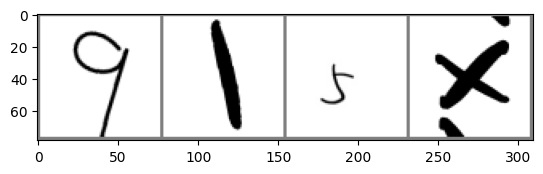

nine	 one	 five	 multiply	


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [6]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channel, 10, kernel_size=3),
                                    nn.BatchNorm2d(10),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(10, 20, kernel_size=3),
                                    nn.BatchNorm2d(20),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(20, 30, kernel_size=3),
                                    nn.BatchNorm2d(30),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(30, 40, kernel_size=3),
                                    nn.BatchNorm2d(40),
                                    nn.ReLU())


        self.fc1 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(40*5*5, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 40*5*5)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return nn.functional.softmax(x, dim=1)

In [7]:
model = CNN(3, len(test_ds.classes))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [8]:
for i, l in test_dataloader:
    print(model(i.to(device)).shape)
    break

torch.Size([1024, 14])


In [9]:
def train(model, train_dataloader, optimizer, loss_func):
    losses = []
    model.train()
    print('Train')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data, labels in tqdm(train_dataloader):
        counter += 1
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        # calculate the loss
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        losses.append(loss.item())
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc, losses

In [10]:
def validate(model, validation_dataloader, loss_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for data, labels in tqdm(validation_dataloader):
            counter += 1
            data = data.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validation_dataloader.dataset))
    return epoch_loss, epoch_acc

In [11]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 20

In [12]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
all_t_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc, all_t_epoch_losses = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    all_t_losses.append(all_t_epoch_losses)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

Epoch 1 of 20
Train


100%|██████████| 42/42 [00:34<00:00,  1.23it/s]


Validation


100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


Training loss: 2.233, training acc: 54.673
Validation loss: 2.083, validation acc: 68.184
--------------------------------------------------
Epoch 2 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


Training loss: 1.983, training acc: 77.714
Validation loss: 1.942, validation acc: 81.563
--------------------------------------------------
Epoch 3 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Training loss: 1.943, training acc: 81.543
Validation loss: 1.918, validation acc: 83.774
--------------------------------------------------
Epoch 4 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


Training loss: 1.926, training acc: 83.136
Validation loss: 1.930, validation acc: 82.837
--------------------------------------------------
Epoch 5 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Training loss: 1.916, training acc: 84.067
Validation loss: 1.908, validation acc: 84.917
--------------------------------------------------
Epoch 6 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Training loss: 1.911, training acc: 84.524
Validation loss: 1.896, validation acc: 85.479
--------------------------------------------------
Epoch 7 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


Training loss: 1.905, training acc: 85.064
Validation loss: 1.894, validation acc: 86.003
--------------------------------------------------
Epoch 8 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Training loss: 1.903, training acc: 85.275
Validation loss: 1.907, validation acc: 84.711
--------------------------------------------------
Epoch 9 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


Training loss: 1.900, training acc: 85.553
Validation loss: 1.892, validation acc: 86.284
--------------------------------------------------
Epoch 10 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Training loss: 1.898, training acc: 85.747
Validation loss: 1.888, validation acc: 86.322
--------------------------------------------------
Epoch 11 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Training loss: 1.895, training acc: 86.014
Validation loss: 1.893, validation acc: 86.303
--------------------------------------------------
Epoch 12 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Training loss: 1.894, training acc: 86.119
Validation loss: 1.889, validation acc: 86.584
--------------------------------------------------
Epoch 13 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Training loss: 1.893, training acc: 86.154
Validation loss: 1.889, validation acc: 86.284
--------------------------------------------------
Epoch 14 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


Training loss: 1.892, training acc: 86.285
Validation loss: 1.886, validation acc: 86.565
--------------------------------------------------
Epoch 15 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Training loss: 1.890, training acc: 86.414
Validation loss: 1.894, validation acc: 86.491
--------------------------------------------------
Epoch 16 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Training loss: 1.843, training acc: 91.350
Validation loss: 1.855, validation acc: 90.425
--------------------------------------------------
Epoch 17 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


Training loss: 1.835, training acc: 92.012
Validation loss: 1.839, validation acc: 91.999
--------------------------------------------------
Epoch 18 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Training loss: 1.834, training acc: 92.175
Validation loss: 1.832, validation acc: 92.168
--------------------------------------------------
Epoch 19 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Training loss: 1.832, training acc: 92.283
Validation loss: 1.840, validation acc: 91.362
--------------------------------------------------
Epoch 20 of 20
Train


100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Validation


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

Training loss: 1.831, training acc: 92.426
Validation loss: 1.828, validation acc: 92.580
--------------------------------------------------


In [13]:
#save the trained model weights
torch.save({
                'epoch': num_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, 'model.pth')

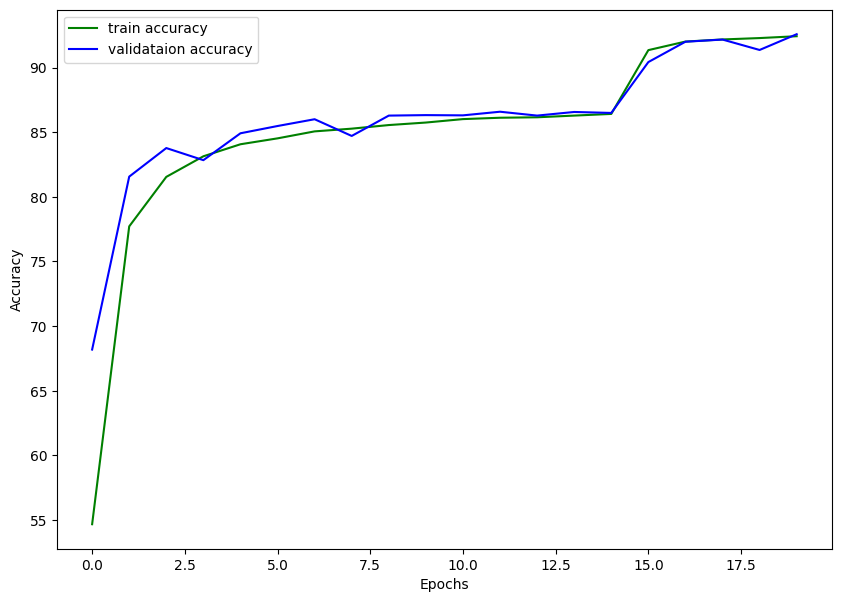

In [14]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

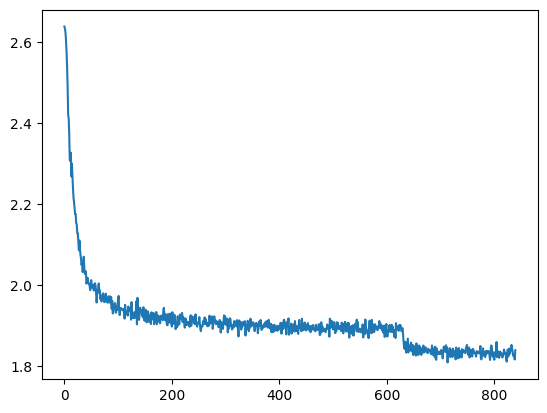

In [15]:
losses = np.array(all_t_losses)
losses =  losses.reshape(len(all_t_losses) * len(all_t_losses[0]))
plt.plot(losses)

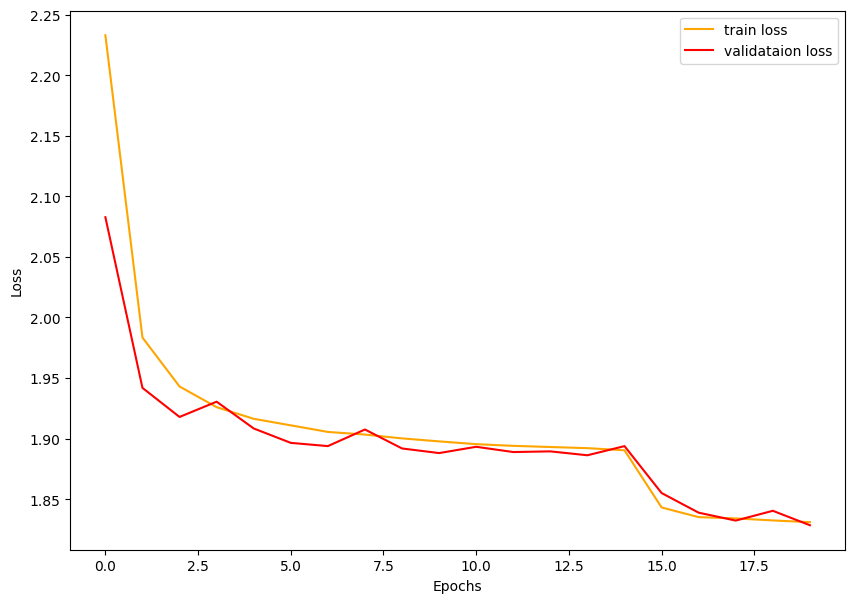

In [16]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

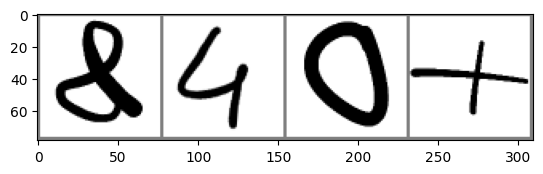

Real value:
eight	 four	 zero	 add	
Predicted value:
three	 four	 zero	 add	


In [17]:
test_fetures, test_labels = next(iter(test_dataloader))
images = []
for i in range(4):
    images.append(test_fetures[i])
imshow(torchvision.utils.make_grid(images)) # show images
print("Real value:")
print(' '.join(f'{train_ds.classes[test_labels[j]]}\t' for j in range(4))) # print labels
print("Predicted value:")
print(' '.join(f'{train_ds.classes[model(test_fetures[j].view(1, 3, 75, 75).to(device)).argmax()]}\t' for j in range(4)))

In [18]:
real_labels = []
predicted_labels = []
for data, labels in test_dataloader:
    data = data.to(device)
    output = model(data).argmax(dim=1).cpu().detach().numpy()
    for i in range(len(output)):
        predicted_labels.append(output[i])
        real_labels.append(labels[i].detach().item())

In [19]:
from sklearn.metrics import classification_report

print(classification_report(predicted_labels, real_labels, target_names=test_ds.classes))

              precision    recall  f1-score   support

         add       0.98      1.00      0.99       349
      divide       0.99      1.00      1.00       327
       eight       0.00      0.00      0.00         0
        five       0.97      0.99      0.98       350
        four       0.98      0.99      0.98       395
    multiply       1.00      0.95      0.97       416
        nine       0.99      0.93      0.96       429
         one       0.99      1.00      0.99       454
       seven       0.98      0.99      0.98       404
         six       0.99      0.84      0.91       444
    subtract       1.00      0.99      1.00       436
       three       0.98      0.76      0.85       421
         two       0.99      0.86      0.92       549
        zero       0.99      0.78      0.87       382

    accuracy                           0.92      5356
   macro avg       0.92      0.86      0.89      5356
weighted avg       0.99      0.92      0.95      5356



c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le